
# Student Stress Monitoring — End‑to‑End ML Pipeline


A clean, modular pipeline to identify the best‑performing model for the *Student Stress Monitoring* datasets on Kaggle.
It includes:
- Robust preprocessing with automatic type detection
- Cross‑validated model comparison (SVM, Random Forest, Gradient Boosting, XGBoost, Logistic Regression)
- Hyperparameter tuning via `RandomizedSearchCV`
- Ensembles (Soft Voting & Stacking)
- Clear evaluation (accuracy, macro/micro F1, confusion matrix, ROC‑AUC)
- Model export with `joblib`

> 📌 **How to use via Kaggle**  
> - Add the dataset to your notebook (from the right sidebar: `Add data`).  
> - Update `DATA_PATH` and `TARGET` if needed.  
> - Run all cells.


In [31]:

# If needed:
# !pip -q install imbalanced-learn xgboost


In [32]:

import os, glob, json, math, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, classification_report,
                             confusion_matrix, roc_auc_score)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

import joblib
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option('display.max_columns', 200)


## Load data

In [33]:

# --- Configure these for your dataset ---
DATA_PATH = '/kaggle/input'  # Kaggle default mount
# Try to auto-locate a CSV under the dataset folder:
candidate_csvs = glob.glob(os.path.join(DATA_PATH, '**', '*.csv'), recursive=True)

print(f"Found {len(candidate_csvs)} CSV file(s). Showing up to 10:")
for p in candidate_csvs[:10]:
    print('-', p)

# Pick the first CSV by default, or set explicitly:
CSV_FILE = candidate_csvs[0] if candidate_csvs else None
print("\nSelected CSV:", CSV_FILE)

assert CSV_FILE is not None, "No CSV file found. Please check DATA_PATH or add the dataset in Kaggle."

df = pd.read_csv(CSV_FILE)
print("\nShape:", df.shape)
display(df.head())
display(df.describe(include='all').transpose())


Found 2 CSV file(s). Showing up to 10:
- /kaggle/input/student-stress-monitoring-datasets/StressLevelDataset.csv
- /kaggle/input/student-stress-monitoring-datasets/Stress_Dataset.csv

Selected CSV: /kaggle/input/student-stress-monitoring-datasets/StressLevelDataset.csv

Shape: (1100, 21)


,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,safety,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,14,20,0,11,2,1,2,4,2,3,3,2,3,2,3,3,2,3,3,2,1
1,15,8,1,15,5,3,1,4,3,1,2,2,1,4,1,5,1,4,5,5,2
2,12,18,1,14,2,1,2,2,2,2,3,2,2,3,3,2,2,3,2,2,1
3,16,12,1,15,4,3,1,3,4,2,2,2,2,4,1,4,1,4,4,5,2
4,16,28,0,7,2,3,5,1,3,2,4,3,4,3,1,2,1,5,0,5,1


,count,mean,std,min,25%,50%,75%,max
anxiety_level,1100.0,11.063636,6.117558,0.0,6.0,11.0,16.0,21.0
self_esteem,1100.0,17.777273,8.944599,0.0,11.0,19.0,26.0,30.0
mental_health_history,1100.0,0.492727,0.500175,0.0,0.0,0.0,1.0,1.0
depression,1100.0,12.555455,7.727008,0.0,6.0,12.0,19.0,27.0
headache,1100.0,2.508182,1.409356,0.0,1.0,3.0,3.0,5.0
blood_pressure,1100.0,2.181818,0.833575,1.0,1.0,2.0,3.0,3.0
sleep_quality,1100.0,2.660000,1.548383,0.0,1.0,2.5,4.0,5.0
breathing_problem,1100.0,2.753636,1.400713,0.0,2.0,3.0,4.0,5.0
noise_level,1100.0,2.649091,1.328127,0.0,2.0,3.0,3.0,5.0
living_conditions,1100.0,2.518182,1.119208,0.0,2.0,2.0,3.0,5.0



### Choose the target column

Set `TARGET` to the correct label column. The dataset variants often use names like `stress_level`, `Stress_Level`, or `Output`.
The helper below will guess common names and fall back to manual selection.


In [34]:

# Guess common target names; override if needed.
COMMON_TARGETS = ['Stress_Level', 'stress_level', 'stress', 'Output', 'label', 'target']
TARGET = None
for t in COMMON_TARGETS:
    if t in df.columns:
        TARGET = t
        break

# If still None, pick the last column as a fallback (edit as needed)
if TARGET is None:
    TARGET = df.columns[-1]

print("Using TARGET =", TARGET)
y = df[TARGET]
X = df.drop(columns=[TARGET])

# Report types
cat_cols = [c for c in X.columns if X[c].dtype == 'object']
num_cols = [c for c in X.columns if c not in cat_cols]

print(f"Categorical features: {len(cat_cols)} ->", cat_cols[:15])
print(f"Numeric features: {len(num_cols)} ->", num_cols[:15])


Using TARGET = stress_level
Categorical features: 0 -> []
Numeric features: 20 -> ['anxiety_level', 'self_esteem', 'mental_health_history', 'depression', 'headache', 'blood_pressure', 'sleep_quality', 'breathing_problem', 'noise_level', 'living_conditions', 'safety', 'basic_needs', 'academic_performance', 'study_load', 'teacher_student_relationship']


## Train/Validation split & preprocessing

In [35]:

# Ensure classification (encode y if object/categorical)
if y.dtype == 'object' or str(y.dtype).startswith('category'):
    y = y.astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'
)

print("X_train shape:", X_train.shape, "| X_test shape:", X_test.shape)


X_train shape: (880, 20) | X_test shape: (220, 20)


## Define base models

In [36]:

models = {
    'svm_rbf': SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE),
    'rf': RandomForestClassifier(random_state=RANDOM_STATE),
    'gb': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'logreg': LogisticRegression(max_iter=2000, n_jobs=None, random_state=RANDOM_STATE)
}

if XGB_AVAILABLE:
    models['xgb'] = XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        tree_method='hist',
        random_state=RANDOM_STATE
    )

pipelines = {name: Pipeline(steps=[('prep', preprocess), ('clf', clf)]) for name, clf in models.items()}
list(pipelines.keys())


['svm_rbf', 'rf', 'gb', 'logreg', 'xgb']

## Cross‑validated model comparison

In [37]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def cv_scores(pipe, X, y, cv, scoring='accuracy'):
    scores = cross_val_score(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    return scores.mean(), scores.std()

summary = []
for name, pipe in pipelines.items():
    acc_mean, acc_std = cv_scores(pipe, X_train, y_train, cv, scoring='accuracy')
    f1_macro_mean, f1_macro_std = cv_scores(pipe, X_train, y_train, cv, scoring='f1_macro')
    summary.append({
        'model': name,
        'cv_accuracy_mean': acc_mean,
        'cv_accuracy_std': acc_std,
        'cv_f1_macro_mean': f1_macro_mean,
        'cv_f1_macro_std': f1_macro_std
    })

cv_df = pd.DataFrame(summary).sort_values('cv_accuracy_mean', ascending=False)
display(cv_df)


,model,cv_accuracy_mean,cv_accuracy_std,cv_f1_macro_mean,cv_f1_macro_std
2,gb,0.879545,0.022556,0.879378,0.022845
3,logreg,0.877273,0.027508,0.877444,0.027993
4,xgb,0.871591,0.027974,0.871636,0.027957
1,rf,0.871591,0.032262,0.871690,0.032520
0,svm_rbf,0.867045,0.028432,0.866958,0.028391


## Hyperparameter tuning (RandomizedSearchCV)

In [38]:

param_distributions = {
    'svm_rbf': {
        'clf__C': np.logspace(-2, 2, 20),
        'clf__gamma': np.logspace(-3, 1, 20)
    },
    'rf': {
        'clf__n_estimators': [100, 200, 400, 800],
        'clf__max_depth': [None, 5, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10]
    },
    'gb': {
        'clf__n_estimators': [100, 200, 400],
        'clf__learning_rate': np.logspace(-3, 0, 10),
        'clf__max_depth': [2, 3, 4]
    },
    'logreg': {
        'clf__C': np.logspace(-3, 2, 15),
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs', 'liblinear', 'saga']
    }
}

if 'xgb' in pipelines:
    param_distributions['xgb'] = {
        'clf__n_estimators': [200, 400, 800],
        'clf__max_depth': [3, 4, 6, 8],
        'clf__learning_rate': np.logspace(-3, -0.1, 10),
        'clf__subsample': [0.7, 0.8, 1.0],
        'clf__colsample_bytree': [0.7, 0.8, 1.0],
        'clf__reg_lambda': np.logspace(-3, 2, 10)
    }

best_pipes = {}
for name, pipe in pipelines.items():
    params = param_distributions.get(name, {})
    if not params:
        print(f"\nSkipping tuning for {name} (no param grid). Training default...")
        tuned = pipe.fit(X_train, y_train)
        best_pipes[name] = tuned
        continue

    print(f"\nTuning {name}...")
    search = RandomizedSearchCV(
        pipe,
        param_distributions=params,
        n_iter=30,
        scoring='f1_macro',
        n_jobs=-1,
        cv=cv,
        random_state=RANDOM_STATE,
        verbose=1
    )
    search.fit(X_train, y_train)
    print("Best CV f1_macro:", search.best_score_)
    print("Best params:", search.best_params_)
    best_pipes[name] = search.best_estimator_



Tuning svm_rbf...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CV f1_macro: 0.8838117650711294
Best params: {'clf__gamma': 0.3359818286283781, 'clf__C': 0.18329807108324356}

Tuning rf...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CV f1_macro: 0.8784696006525314
Best params: {'clf__n_estimators': 100, 'clf__min_samples_split': 2, 'clf__max_depth': 5}

Tuning gb...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CV f1_macro: 0.9014051967701745
Best params: {'clf__n_estimators': 100, 'clf__max_depth': 4, 'clf__learning_rate': 0.01}

Tuning logreg...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CV f1_macro: 0.885815010766754
Best params: {'clf__solver': 'lbfgs', 'clf__penalty': 'l2', 'clf__C': 0.001}

Tuning xgb...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CV f1_macro: 0.8909508756431002
Best params: {'clf__subsample': 1.0, 'clf__reg_lambda': 27.825594022071257, 'clf__n_estimat

## Evaluate tuned models on the test set

In [39]:

results = []
for name, model in best_pipes.items():
    y_pred = model.predict(X_test)
    y_proba = None
    try:
        y_proba = model.predict_proba(X_test)
    except Exception:
        pass

    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)

    row = {'model': name, 'accuracy': acc, 'f1_macro': f1_macro, 'f1_micro': f1_micro,
           'precision_macro': prec, 'recall_macro': rec}

    # Multiclass ROC-AUC (OVR) if probabilities available
    if y_proba is not None and y_proba.ndim == 2:
        try:
            rocauc = roc_auc_score(y_test, y_proba, multi_class='ovr')
            row['roc_auc_ovr'] = rocauc
        except Exception:
            row['roc_auc_ovr'] = np.nan
    results.append(row)

test_df = pd.DataFrame(results).sort_values('f1_macro', ascending=False)
display(test_df)

best_name = test_df.iloc[0]['model']
print("\nBest tuned base model by f1_macro:", best_name)


,model,accuracy,f1_macro,f1_micro,precision_macro,recall_macro,roc_auc_ovr
0,svm_rbf,0.886364,0.888966,0.886364,0.915825,0.886386,0.983072
3,logreg,0.881818,0.882188,0.881818,0.882610,0.882132,0.967772
1,rf,0.877273,0.877086,0.877273,0.879702,0.877377,0.984757
4,xgb,0.872727,0.872674,0.872727,0.874423,0.872998,0.982873
2,gb,0.859091,0.859131,0.859091,0.859065,0.859359,0.965887



Best tuned base model by f1_macro: svm_rbf


### Confusion matrix & report for the best base model

              precision    recall  f1-score   support

           0       1.00      0.77      0.87        74
           1       1.00      0.89      0.94        72
           2       0.75      1.00      0.86        74

    accuracy                           0.89       220
   macro avg       0.92      0.89      0.89       220
weighted avg       0.92      0.89      0.89       220



<Figure size 640x480 with 0 Axes>

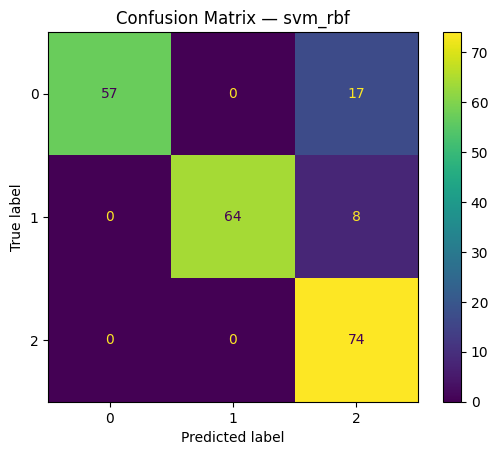

In [40]:

best_model = best_pipes[best_name]
y_pred_best = best_model.predict(X_test)

print(classification_report(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure()
disp.plot(values_format='d')
plt.title(f'Confusion Matrix — {best_name}')
plt.show()


## Ensembles: Soft Voting and Stacking

In [41]:

# Select top 3 models by validation score for ensembles
top_models = test_df.head(3)['model'].tolist()
print("Top models for ensembles:", top_models)

estimators = [(m, best_pipes[m]) for m in top_models]

# Soft Voting (requires predict_proba support; models without it will be ignored)
voting_estimators = [(name, est) for name, est in estimators]
try:
    voting = VotingClassifier(estimators=voting_estimators, voting='soft', n_jobs=None)
    voting.fit(X_train, y_train)
    y_pred_vote = voting.predict(X_test)
    vote_row = {
        'model': 'voting_soft',
        'accuracy': accuracy_score(y_test, y_pred_vote),
        'f1_macro': f1_score(y_test, y_pred_vote, average='macro'),
        'f1_micro': f1_score(y_test, y_pred_vote, average='micro'),
        'precision_macro': precision_score(y_test, y_pred_vote, average='macro', zero_division=0),
        'recall_macro': recall_score(y_test, y_pred_vote, average='macro', zero_division=0)
    }
    results.append(vote_row)
    print("Soft Voting scores added.")
except Exception as e:
    print("Soft Voting failed:", e)

# Stacking (use LogisticRegression as meta-model by default)
try:
    stack = StackingClassifier(
        estimators=voting_estimators,
        final_estimator=LogisticRegression(max_iter=2000, n_jobs=None, random_state=RANDOM_STATE),
        cv=5,
        n_jobs=-1,
        passthrough=False
    )
    stack.fit(X_train, y_train)
    y_pred_stack = stack.predict(X_test)
    stack_row = {
        'model': 'stacking',
        'accuracy': accuracy_score(y_test, y_pred_stack),
        'f1_macro': f1_score(y_test, y_pred_stack, average='macro'),
        'f1_micro': f1_score(y_test, y_pred_stack, average='micro'),
        'precision_macro': precision_score(y_test, y_pred_stack, average='macro', zero_division=0),
        'recall_macro': recall_score(y_test, y_pred_stack, average='macro', zero_division=0)
    }
    results.append(stack_row)
    print("Stacking scores added.")
except Exception as e:
    print("Stacking failed:", e)

ensemble_df = pd.DataFrame(results).sort_values('f1_macro', ascending=False)
display(ensemble_df)


Top models for ensembles: ['svm_rbf', 'logreg', 'rf']
Soft Voting scores added.
Stacking scores added.


,model,accuracy,f1_macro,f1_micro,precision_macro,recall_macro,roc_auc_ovr
5,voting_soft,0.890909,0.891562,0.890909,0.895253,0.891016,NaN
6,stacking,0.890909,0.890802,0.890909,0.891750,0.891016,NaN
0,svm_rbf,0.886364,0.888966,0.886364,0.915825,0.886386,0.983072
3,logreg,0.881818,0.882188,0.881818,0.882610,0.882132,0.967772
1,rf,0.877273,0.877086,0.877273,0.879702,0.877377,0.984757
4,xgb,0.872727,0.872674,0.872727,0.874423,0.872998,0.982873
2,gb,0.859091,0.859131,0.859091,0.859065,0.859359,0.965887


## Feature importance (permutation)

,perm_importance
mental_health_history,0.130455
sleep_quality,0.083636
future_career_concerns,0.078636
bullying,0.075000
headache,0.070000
self_esteem,0.069091
depression,0.054545
social_support,0.054091
teacher_student_relationship,0.053182
safety,0.052273


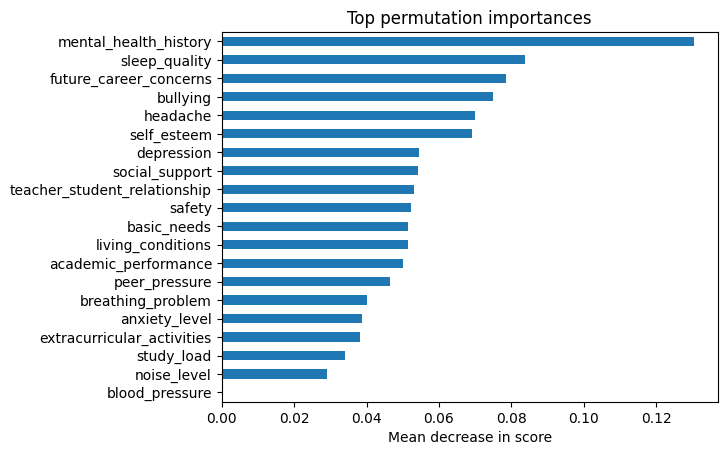

In [42]:

# Permutation importance uses fitted pipeline safely (on test set); may take time.
try:
    r = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
    # Retrieve transformed feature names from ColumnTransformer
    # Build feature name list after preprocessing
    ohe = best_model.named_steps['prep'].named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = list(ohe.get_feature_names_out(cat_cols)) if len(cat_cols) else []
    feature_names = num_cols + cat_feature_names

    importances = pd.Series(r.importances_mean, index=feature_names)
    importances = importances.sort_values(ascending=False).head(30)
    display(importances.to_frame('perm_importance').head(20))

    plt.figure()
    importances.head(20).plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.title('Top permutation importances')
    plt.xlabel('Mean decrease in score')
    plt.show()
except Exception as e:
    print("Permutation importance failed:", e)


## Save best model

In [43]:

# Pick the overall best by f1_macro
final_table = pd.DataFrame(results).sort_values('f1_macro', ascending=False)
best_overall = final_table.iloc[0]['model']
print("Best overall model:", best_overall)

final_model = None
if best_overall in best_pipes:
    final_model = best_pipes[best_overall]
elif best_overall == 'voting_soft':
    final_model = voting
elif best_overall == 'stacking':
    final_model = stack

assert final_model is not None, "No final model selected"

ARTIFACT_PATH = '/kaggle/working/best_student_stress_model.joblib'
joblib.dump(final_model, ARTIFACT_PATH)
print("Saved:", ARTIFACT_PATH)


Best overall model: voting_soft
Saved: /kaggle/working/best_student_stress_model.joblib


## Appendix: Quick re-run with a different target

In [44]:

# If you need to change the target and re-run:
# TARGET = 'YourNewTarget'
# y = df[TARGET]
# X = df.drop(columns=[TARGET])
# (then re-run from preprocessing onward)
pass


## 🔄 Export Trained Model for Web App Backend

In [45]:
import os
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Example: define features/target (⚠️ replace "stress_level" with the actual column name in your CSV)
X = df.drop("stress_level", axis=1)
y = df["stress_level"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train lightweight ML model (Random Forest here, LogisticRegression also works)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# ✅ Save into model/ folder
os.makedirs("model", exist_ok=True)
joblib.dump(model, "model/stress_model.pkl")
joblib.dump(scaler, "model/preprocessing.pkl")

print("✅ Saved: model/stress_model.pkl and model/preprocessing.pkl")


✅ Saved: model/stress_model.pkl and model/preprocessing.pkl
